In [4]:
import zipfile
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import timeit

import pandas as pd
import pickle
import cv2
import skimage.morphology as morp
from skimage.filters import rank
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.regularizers import L2
from tensorflow import keras
from tensorflow.keras import layers

%matplotlib inline

# Outline
* [Download Data](#Download-Data)
* [Data Exploration](#Data-Exploration)
* [Data Preprocessing](#Data-Preprocessing)

## Download Data
- Download data ffrom the repo
- Unzip the data from dataroot folder (with dataroot as the folder default)
- read in sign names from csv file

In [ ]:
def unzip_traffic_signs(directory='dataroot/'):
    """
    Unzips traffic sign files from a specified directory.

    Args:
        directory (str): The directory path where the traffic sign files are located. 
                         Defaults to 'dataroot/'.

    Raises:
        Exception: If an error occurs during the unzipping process, the exception is printed.

    Returns:
        None: The function does not return any value.
    """
    try:
        for file in os.listdir(directory):
            print(file)
            if file.endswith('.zip'):
                print('Unzipping ' + file)
                with zipfile.ZipFile(directory + file, 'r') as zip_ref:
                    print('Extracting ' + file)
                    zip_ref.extractall(directory)
    except Exception as e:
        print(e)

In [ ]:
def download_traffic_signs(directory='dataroot/', unzip_data=False, data_zip_link=[
    'https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectRTS/data/data_1.zip',
    'https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectRTS/data/data_2.zip',
    'https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectRTS/data/data_3.zip'
]):
    """
    Downloads traffic sign data from specified links and optionally unzips the data files.

    Args:
        directory (str): The directory path where the data files will be downloaded. 
                        Defaults to 'dataroot/'.
        unzip_data (bool): Whether to unzip the downloaded data files or not. 
                        Defaults to False.
        data_zip_link (list): A list of URLs pointing to the data zip files. 
                            Defaults to a list of three URLs.

    Raises:
        Exception: If an error occurs during the downloading or unzipping process, the exception is printed.

    Returns:
        None: The function does not return any value.
    """
    try:
        !mkdir $directory
        try:
            for link in data_zip_link:
                !wget -P $directory $link
                print(f"Data file {link} downloaded")
            if unzip_data:
                unzip_traffic_signs(directory)
        except Exception as e:
            print('Error downloading data')
            print(e)
    except Exception as e:
        print('Error making directory')
        print(e)    

In [5]:
def download_traffic_names(sign_name_url ="https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectRTS/data/signnames.csv"):
    """
    Downloads traffic sign names from a specified URL.

    Args:
        sign_name_url (str): The URL pointing to the sign names file. 
                            Defaults to a URL pointing to a CSV file.

    Raises:
        Exception: If an error occurs during the downloading process, the exception is printed.

    Returns:
        None: The function does not return any value.
    """
    try:
        df = pd.read_csv(sign_name_url)
        signnames = pd.Series(df.SignName.values,index=df.ClassId).to_dict()
        return signnames    
    except Exception as e:
        print('Error downloading sign names')
        print(e)

In [6]:
def load_traffic_images(directory='dataroot/'):
    """
    Loads traffic sign images from a specified directory.

    Args:
        directory (str): The directory path where the traffic sign files are located.
                        Defaults to 'dataroot/'.
                        
    Raises:
        Exception: If an error occurs during the loading process, the exception is printed.

    Returns:
        list: A list of traffic sign images.    
    """
    signimages = []
    try:
        for file in os.listdir(directory):
            if file.endswith('.p'):
                signimages.append(pickle.load(open(directory + file, 'rb')))
        return signimages
    except Exception as e:
        print('Error loading images')
        print(e)

In [7]:
train, valid, test = load_traffic_images(directory='dataroot/')
signnames = download_traffic_names()

## Data Exploration
- Look and sign image name keys
- Get shape of training, validation and test data
- Plot a sample of the images
- Pixel intensity distribution
- Plot a histogram of the number of images per class

In [ ]:
print("Sign Names: ", signnames.values())

In [ ]:
print("Key Values: ", train.keys())

In [8]:
train_images, train_labels = train['features'], train['labels']
valid_images, valid_labels = valid['features'], valid['labels']
test_images, test_labels = test['features'], test['labels']

The dict_keys are `coords`, `labels`, `features`, and `sizes`.
* `sizes`: This is a tuple (width, height) containing the original width and height of each image.
* `coords`: This is the coordinates of a bounding box around the sign in the image.
* `features`: This is a 4D array containing the actual image data. Images are represented as arrays of pixel values. This key is what we will be using for image analysis and model training. (num examples, width, height, channels (RGB))) 
* `labels`: This contains the labels (one-hot-encoded) associated with each image. This is what we will be using for model training and evaluation.

In [ ]:
print("Shape of features: ", train['features'].shape)
print("Shape of labels: ", train['labels'].shape)
print("Shape of sizes: ", train['sizes'].shape)

In [ ]:
print("Number of training examples: ", train_images.shape[0])
print("Number of validation examples: ", valid_images.shape[0])
print("Number of testing examples: ", test_images.shape[0])

In [ ]:
print("Image data shape: ", train_images[0].shape)
print("Number of classes: ", len(np.unique(train_labels)))

In [9]:
def plot_image(images, labels, signnames, index, cmap=None):
    """
    Plots a traffic sign image.

    Args:
        image_dict (dict): A dictionary containing traffic sign images.
        index (int): The index of the image to plot.
    """
    image = images[index]
    plt.imshow(image, cmap=cmap)
    plt.title(f'{labels[index]} = {signnames[labels[index]]}')
    plt.show()

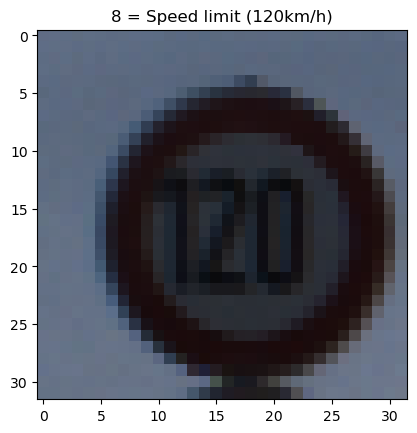

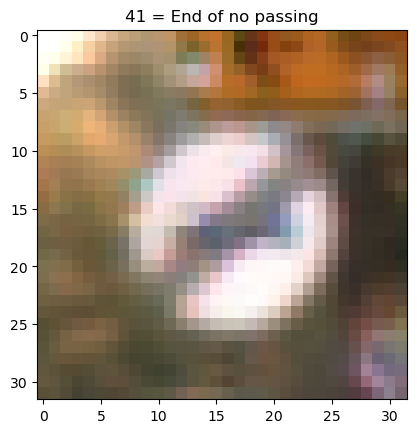

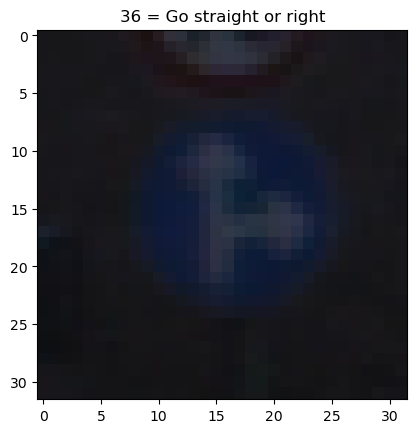

In [10]:
plot_image(train_images, train_labels, signnames, 123)
plot_image(valid_images, valid_labels, signnames, 123)
plot_image(test_images, test_labels, signnames, 123)

In [ ]:
def plot_all_signs(images, labels, signnames, cmap=None):

    unique_labels = np.unique(labels)
    num_labels = len(unique_labels)
    num_cols = 4
    num_rows = (num_labels - 1) // num_cols + 1

    fig = plt.figure(figsize=(20, 16))

    for i, label in enumerate(unique_labels, 1):
        image = images[labels == label][0]
        ax = fig.add_subplot(num_rows, num_cols, i)
        ax.imshow(image, cmap=cmap)
        ax.set_title(f'{label} = {signnames[label]}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
plot_all_signs(train_images, train_labels, signnames)

In [ ]:
def plot_pixel_distribution(images, labels, signnames, selected_labels=None):
    
    unique_labels = np.unique(labels)

    if selected_labels is not None:
        unique_labels = unique_labels[selected_labels]

    for label in unique_labels:
        label_indices = np.where(labels == label)[0]
        label_images = images[label_indices]

        fig, axes = plt.subplots(1, 2, figsize=(12, 6))

        # Plot pixel distribution
        pixel_values = label_images.flatten()
        axes[0].hist(pixel_values, bins=256, color='gray', alpha=0.7)
        axes[0].set_title(f"Pixel Distribution - {signnames[label]}")
        axes[0].set_xlabel('Pixel Intensity')
        axes[0].set_ylabel('Frequency')

        # Plot box and whisker plot
        axes[1].boxplot(pixel_values)
        axes[1].set_title(f"Box and Whisker Plot - {signnames[label]}")
        axes[1].set_ylabel('Pixel Intensity')

        plt.tight_layout()
        plt.show()



In [ ]:
plot_pixel_distribution(train_images, train_labels, signnames, selected_labels=[0, 1, 2])

In [18]:
def plot_label_counts(labels, signnames, title=""):

    unique_labels, label_counts = np.unique(labels, return_counts=True)
    sorted_indices = np.argsort(label_counts)[::-1]  # Sort indices in descending order based on count

    sorted_labels = unique_labels[sorted_indices]
    sorted_counts = label_counts[sorted_indices]

    fig = plt.figure(figsize=(20, 16))
    plt.bar(range(len(sorted_labels)), sorted_counts)
    plt.xticks(range(len(sorted_labels)), [signnames[i] for i in sorted_labels], rotation='vertical')
    plt.title(f"Label Counts of {title} Data")
    plt.show()

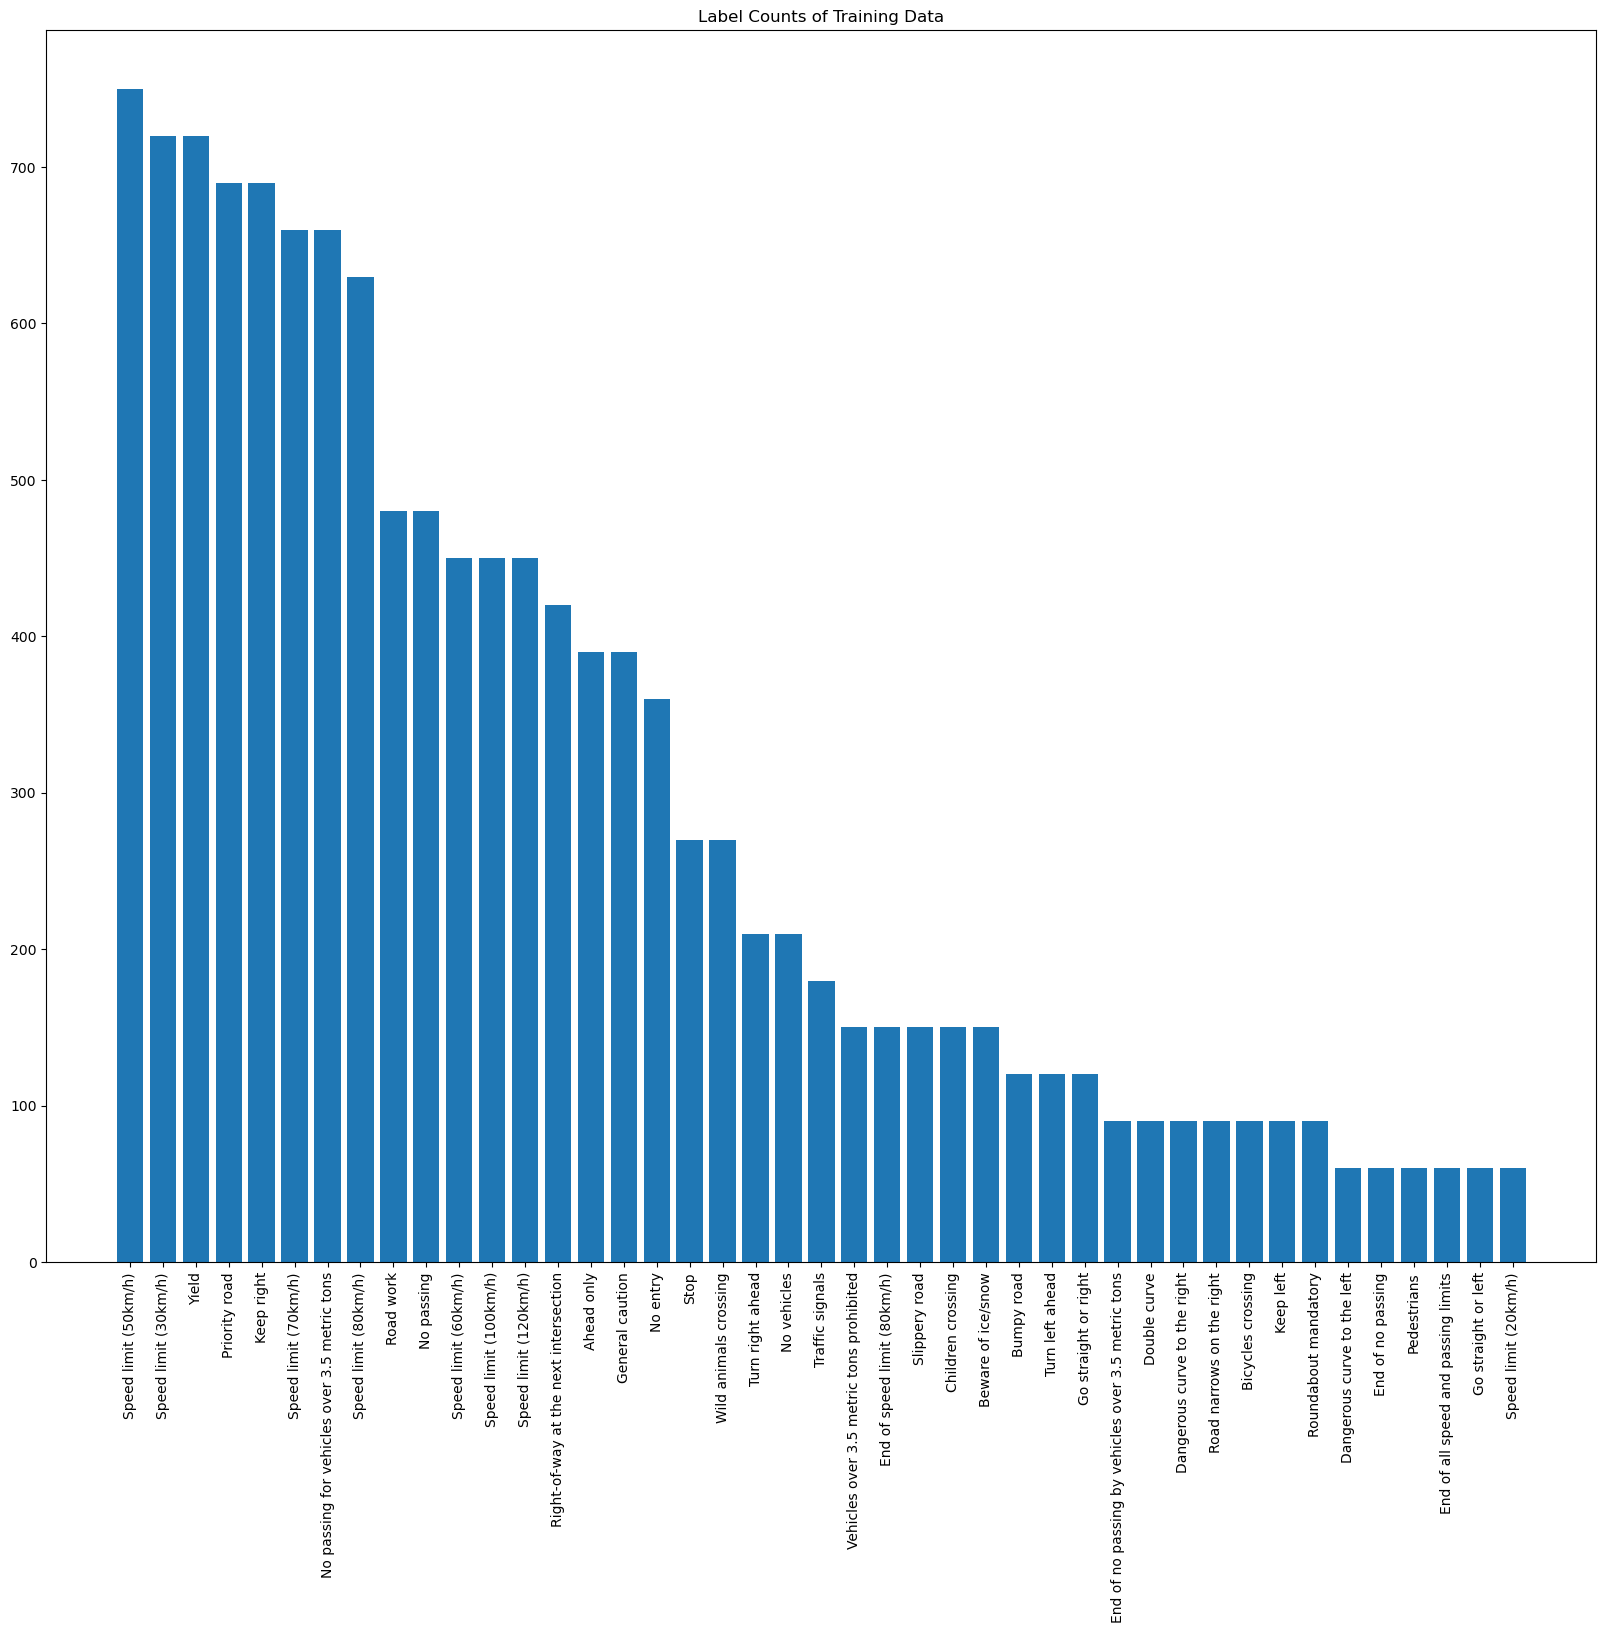

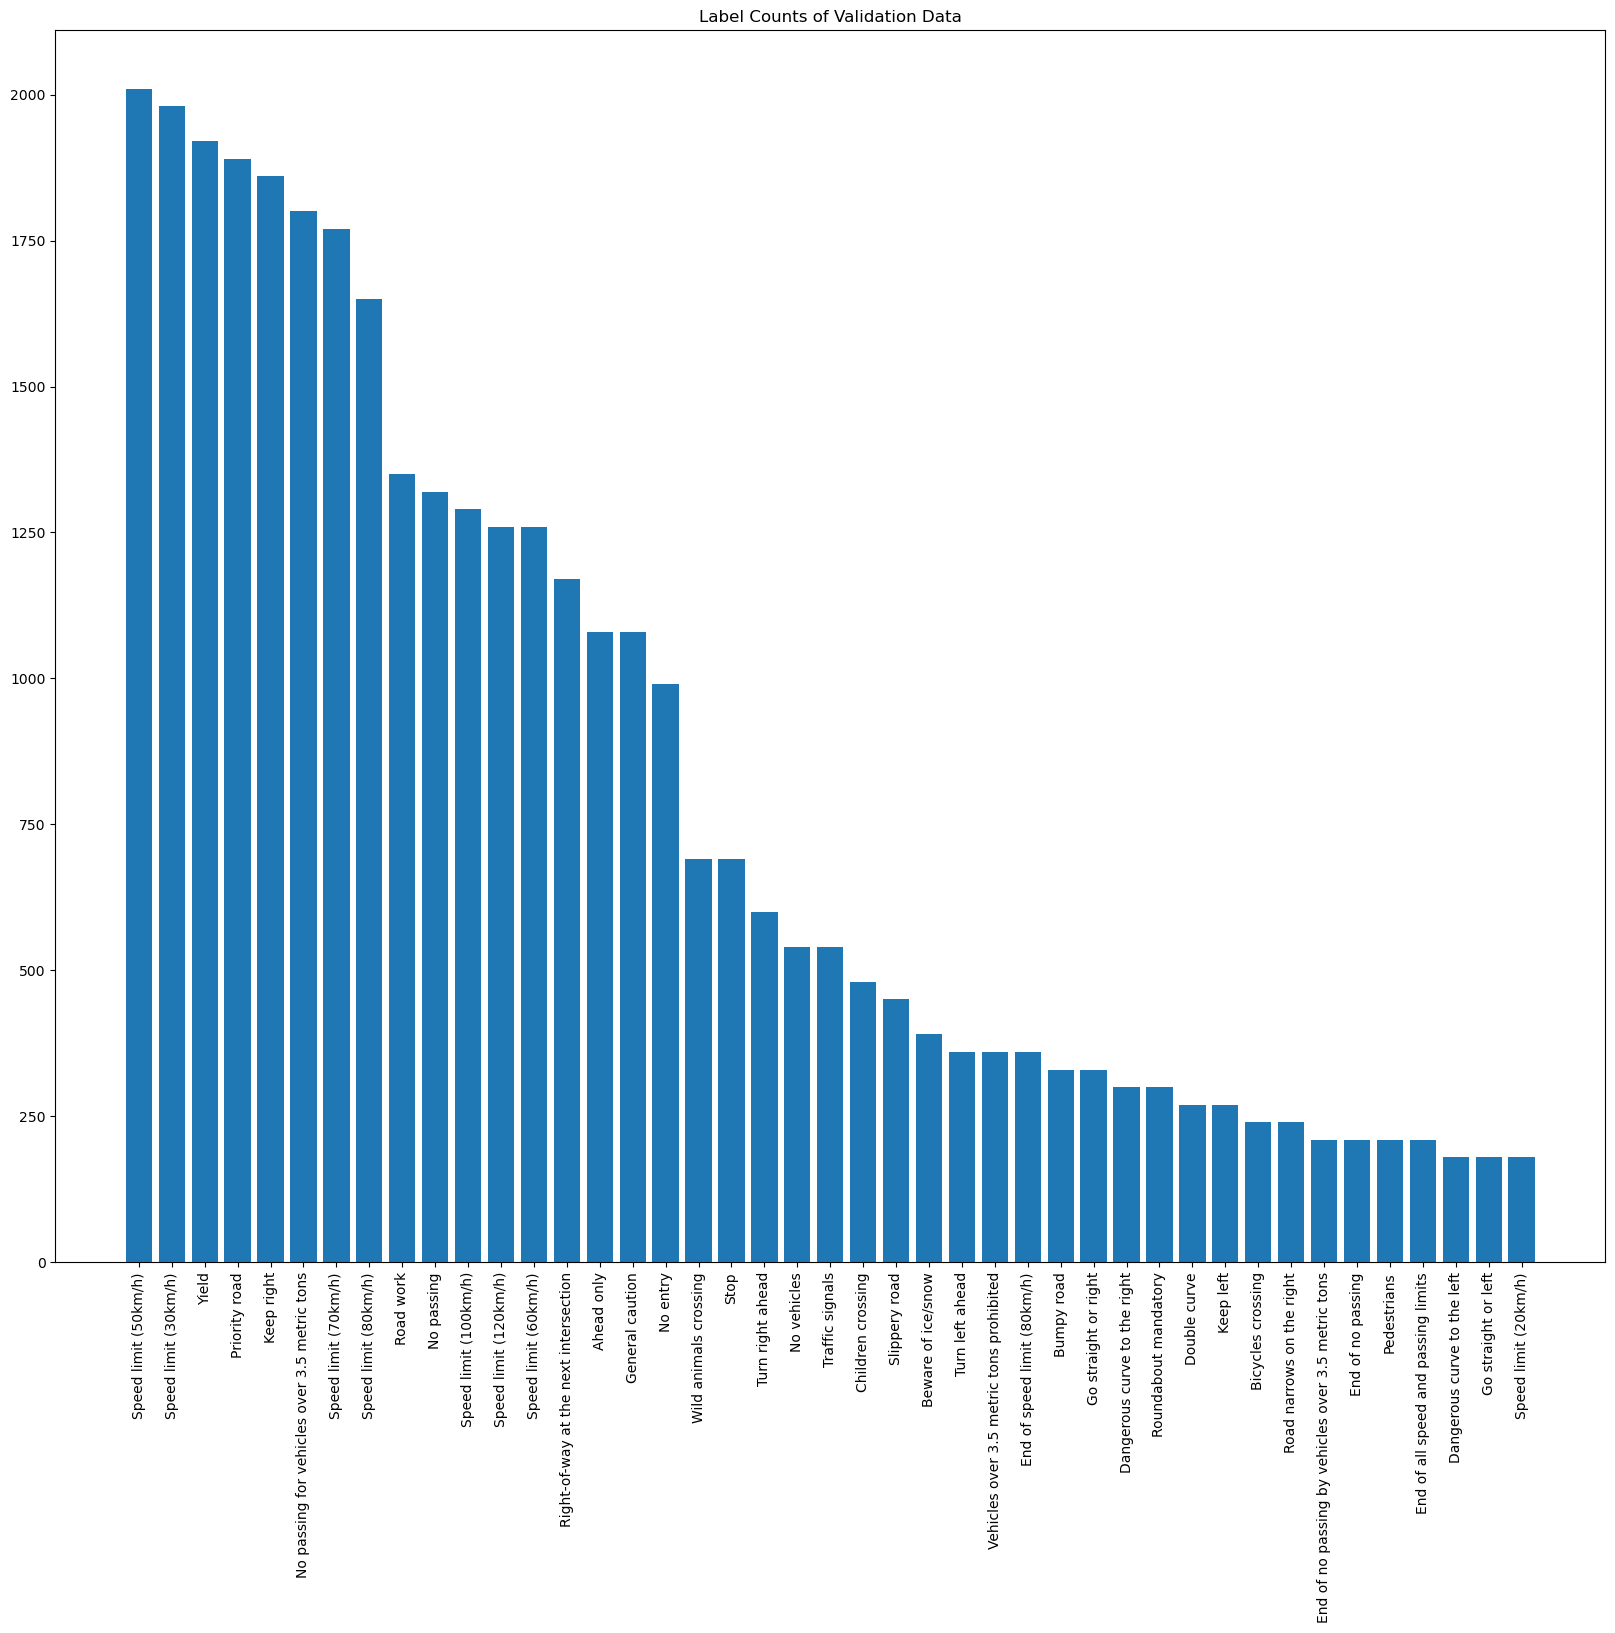

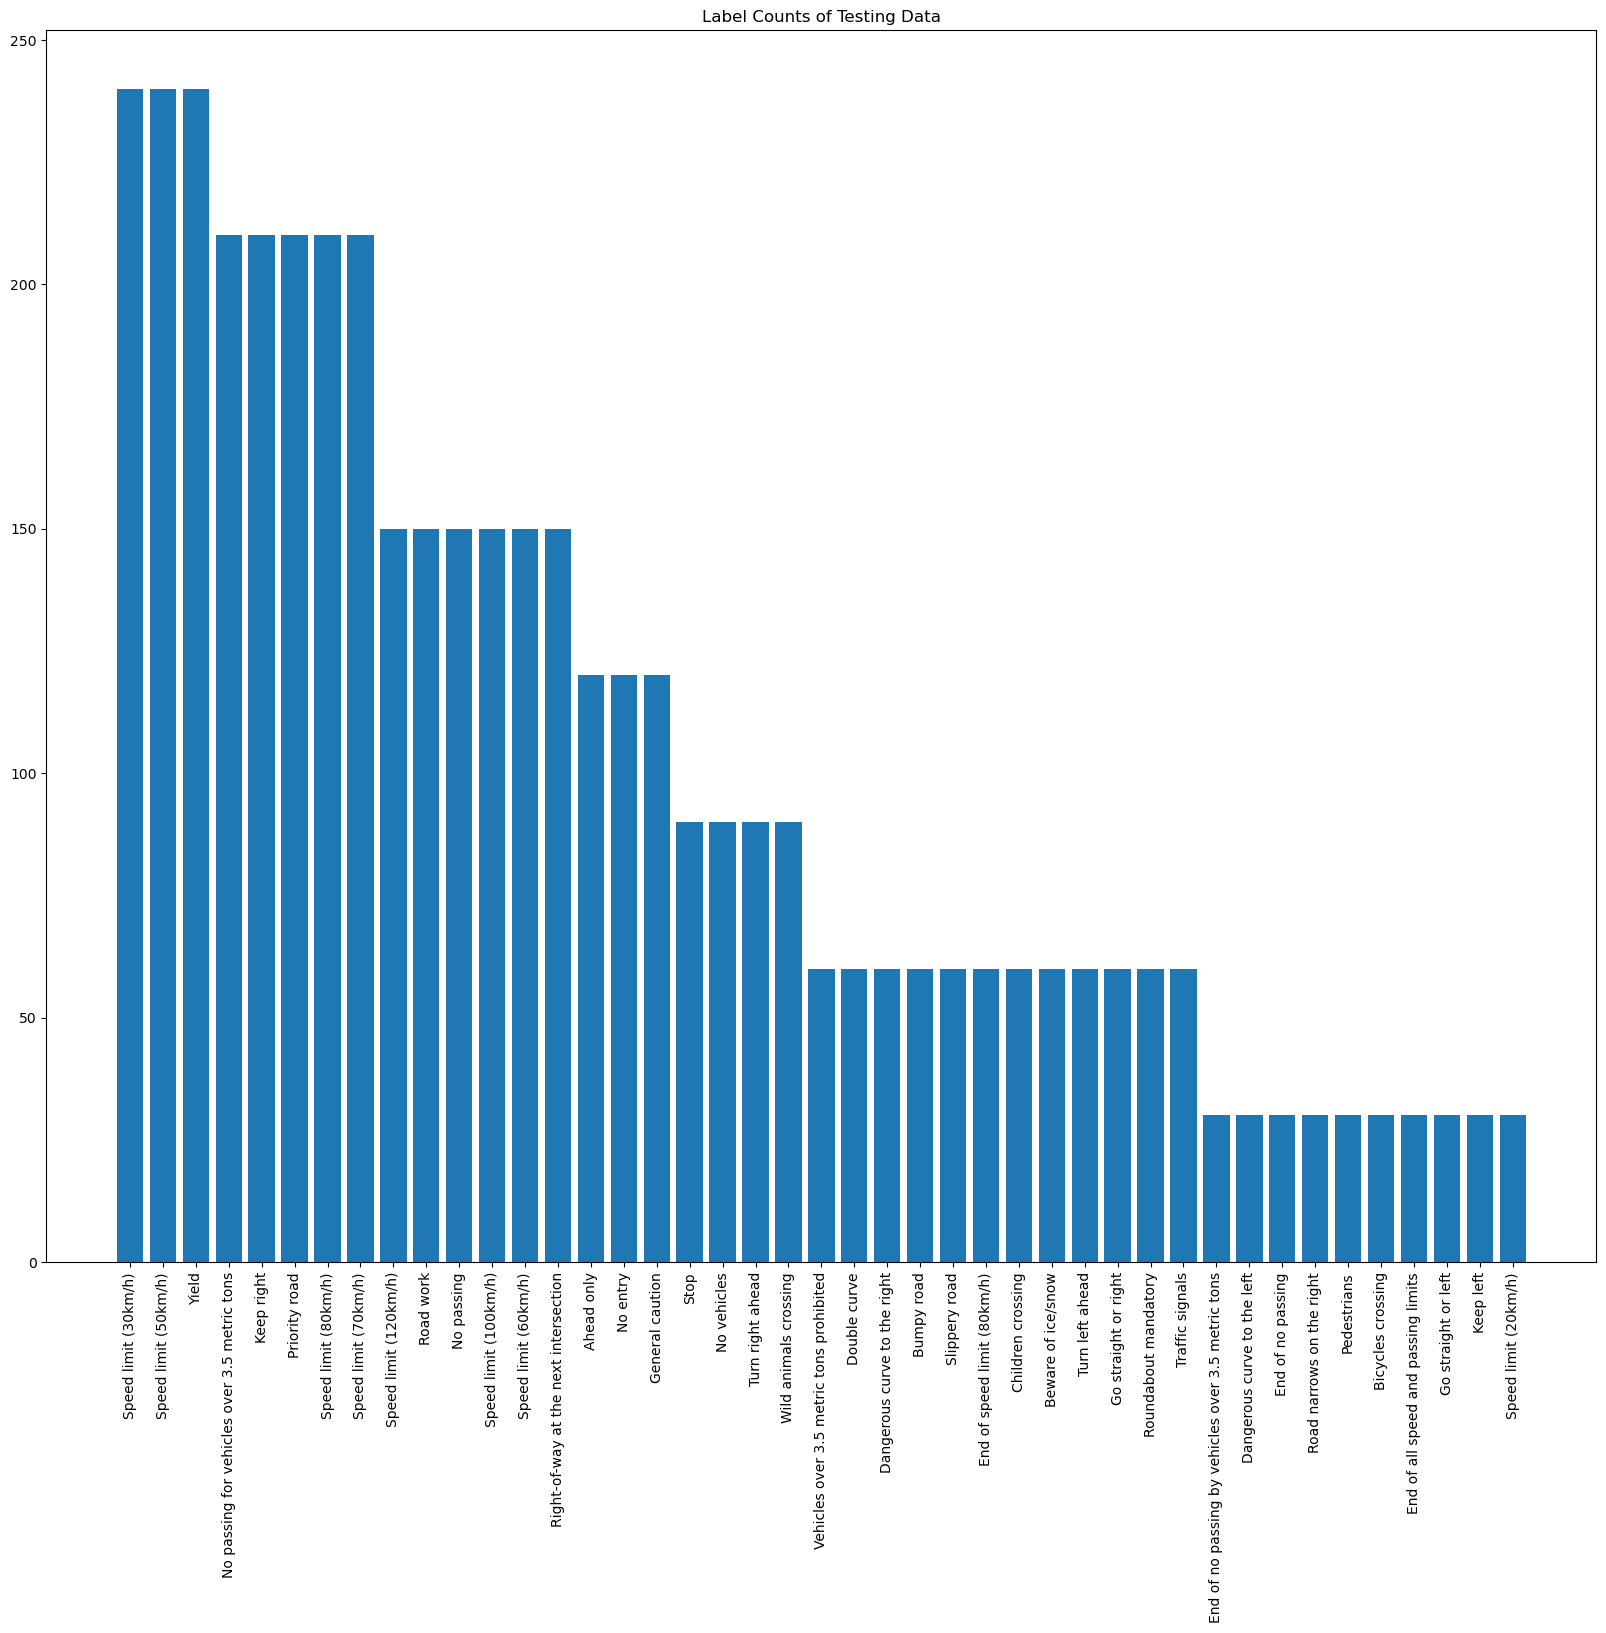

In [19]:
plot_label_counts(train_labels, signnames, "Training")
plot_label_counts(valid_labels, signnames, "Validation")
plot_label_counts(test_labels, signnames, "Testing")

## Data Preprocessing
- Shuffle the training data
- Grayscale the images
- Local Histogram Equalization
- Normalize the data

### Shuffle

In [11]:
def shuffle_data(images, labels):
    """
    Shuffles the data.

    Args:
        images (numpy.ndarray): An array of images.
        labels (numpy.ndarray): An array of labels.

    Returns:
        numpy.ndarray, numpy.ndarray: The shuffled images and labels.
    """
    indices = np.arange(len(images))
    np.random.shuffle(indices)
    return images[indices], labels[indices]

In [12]:
# data before shuffling
print("Before shuffling: ", train_labels[:10])

# shuffle data
train_images, train_labels = shuffle_data(train_images, train_labels)

# data after shuffling
print("After shuffling: ", train_labels[:10])

Before shuffling:  [16  1 38 33 11 38 18 12 25 35]
After shuffling:  [ 8 28 13  4 12 29 31  4  9 19]


### Normalize

In [13]:
def normalize_images(images):
    """
    Normalize images to [0, 1] scale.

    Args:
        images (numpy.ndarray): An array of images.

    Returns:
        numpy.ndarray: The normalized images.
    """
    # 0,255 -> 0,1
    return images / 255.0

In [14]:
train_images_P = normalize_images(train_images)
valid_images_P = normalize_images(valid_images)
test_images_P = normalize_images(test_images)

In [20]:
def oversample_images(images, labels, signnames, min_count=300):
    """
    Oversamples images to a minimum count.

    Args:
        images (numpy.ndarray): An array of images.
        labels (numpy.ndarray): An array of labels.
        min_count (int): The minimum number of images per label.

    Returns:
        numpy.ndarray, numpy.ndarray: The oversampled images and labels.
    """
    unique_labels, label_counts = np.unique(labels, return_counts=True)
    max_count = np.max(label_counts)

    for label in unique_labels:
        label_indices = np.where(labels == label)[0]
        label_images = images[label_indices]
        label_count = len(label_images)

        if label_count < min_count:
            num_copies = int(np.ceil((max_count - label_count) / label_count))
            label_images = np.repeat(label_images, num_copies, axis=0)
            label_images = label_images[:max_count - label_count]
            label_labels = np.repeat(label, len(label_images))
            images = np.concatenate((images, label_images), axis=0)
            labels = np.concatenate((labels, label_labels), axis=0)

    return shuffle_data(images, labels)

In [21]:
train_images_P, train_labels = oversample_images(train_images_P, train_labels, signnames)

In [22]:
train_labels_P = tf.one_hot(train_labels, 43)
valid_labels_P = tf.one_hot(valid_labels, 43)
test_labels_P = tf.one_hot(test_labels, 43)

In [23]:
train_images_Pt = tf.convert_to_tensor(train_images_P, dtype=tf.float32)
valid_images_Pt = tf.convert_to_tensor(valid_images_P, dtype=tf.float32)
test_images_Pt = tf.convert_to_tensor(test_images_P, dtype=tf.float32)

In [24]:
print("Shape of training images: ", train_images_P.shape)
print("Shape of validation images: ", valid_images_P.shape)
print("Shape of testing images: ", test_images_P.shape)

print("Shape of training labels: ", train_labels_P.shape)
print("Shape of validation labels: ", valid_labels_P.shape)
print("Shape of testing labels: ", test_labels_P.shape)


Shape of training images:  (28890, 32, 32, 3)
Shape of validation images:  (34799, 32, 32, 3)
Shape of testing images:  (4410, 32, 32, 3)
Shape of training labels:  (28890, 43)
Shape of validation labels:  (34799, 43)
Shape of testing labels:  (4410, 43)


Not sure if we should return to removing outlier images or not-- think of a way to handle unbalanced classes.

## Model Architecture

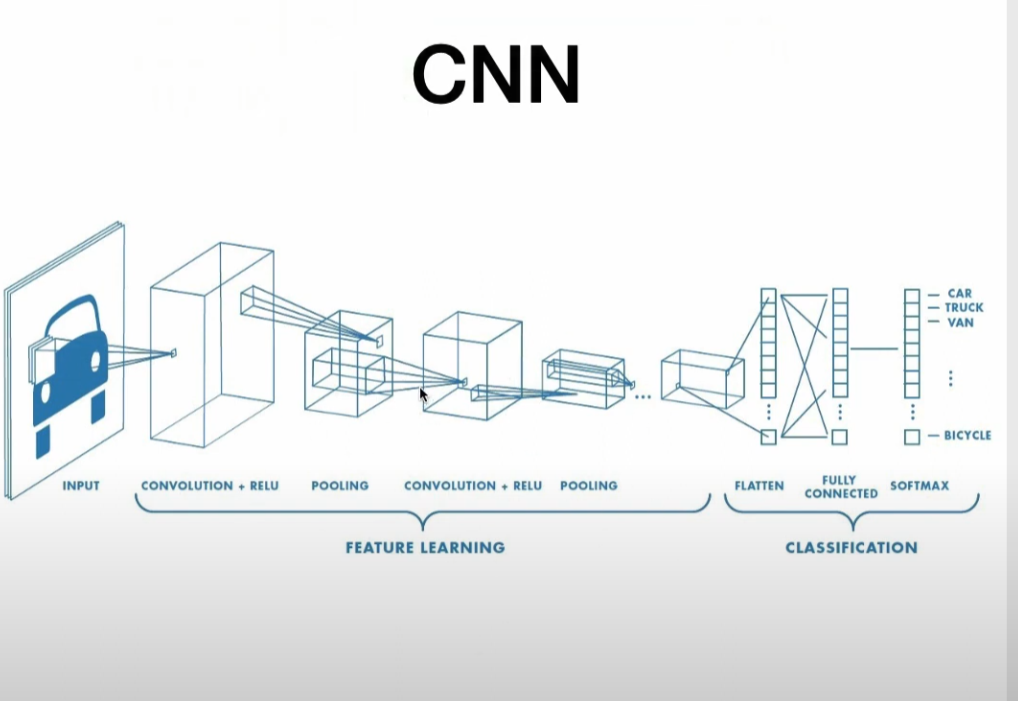

I will first implement my own CNN architecture and then compare it to the LeNet architecture.

Here's the architecture of my model:

Input => Convolution + ReLu => MaxPooling => Convolution + ReLu => MaxPooling => Flatten => Fully Connected (Dense) + ReLu => Fully Connected (Dense) + Softmax => Output


### CNN Baseline Model

In [25]:
def plot_accuracy_loss(model_history, model_name=""):
 
    fig, ax1 = plt.subplots(figsize=(15, 8))

    # Accuracy plot
    ax1.plot(model_history.history['categorical_accuracy'], color='tab:blue')
    ax1.plot(model_history.history['val_categorical_accuracy'], color='tab:orange')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylim([0, 1])

    # Loss plot
    ax2 = ax1.twinx()
    ax2.plot(model_history.history['loss'], color='tab:green')
    ax2.plot(model_history.history['val_loss'], color='tab:red')
    ax2.set_ylabel('Loss')

    # Legend, title
    lines = ax1.get_lines() + ax2.get_lines()
    ax1.legend(lines, ['Train Accuracy', 'Validation Accuracy', 'Train Loss', 'Validation Loss'], loc='lower left')
    plt.title('Accuracy and Loss for ' + model_name)
    plt.show()


In [26]:
# Define the model architecture
cnn_baseline = keras.Sequential([
    # strides and padding are the default values but adding them for better understanding
    layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1,1), padding='valid', activation='relu', input_shape=train_images_Pt.shape[1:]), # convulation layer + relu activation
    layers.MaxPooling2D((2, 2)), # max pooling layer
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'), # convulation layer + relu activation 
    layers.MaxPooling2D((2, 2)),# max pooling layer

    layers.Flatten(), # flatten layer
    
    layers.Dense(64, activation='relu'), # fully connected layer + relu activation
    layers.Dense(43, activation='softmax')  # 43 classes
])

# configure parameters for the model
loss = keras.losses.CategoricalCrossentropy() # loss function for multi-class classification
optimizer = keras.optimizers.Adam(learning_rate=0.001) # adam optimizer
metrics = [keras.metrics.CategoricalAccuracy()] # accuracy metric

# compile the model
cnn_baseline.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# print model summary
cnn_baseline.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                73792     
_________________________________________________________________
dense_1 (Dense)              (None, 43)                2

Epoch 1/10
452/452 [==============================] - 26s 43ms/step - loss: 2.4015 - categorical_accuracy: 0.3883 - val_loss: 1.4363 - val_categorical_accuracy: 0.6140
Epoch 2/10
452/452 [==============================] - 12s 28ms/step - loss: 0.3124 - categorical_accuracy: 0.9156 - val_loss: 1.3780 - val_categorical_accuracy: 0.7036
Epoch 3/10
452/452 [==============================] - 13s 29ms/step - loss: 0.1302 - categorical_accuracy: 0.9655 - val_loss: 1.1969 - val_categorical_accuracy: 0.7615
Epoch 4/10
452/452 [==============================] - 13s 29ms/step - loss: 0.0737 - categorical_accuracy: 0.9809 - val_loss: 1.3353 - val_categorical_accuracy: 0.7592
Epoch 5/10
452/452 [==============================] - 13s 29ms/step - loss: 0.0466 - categorical_accuracy: 0.9870 - val_loss: 1.3070 - val_categorical_accuracy: 0.7720
Epoch 6/10
452/452 [==============================] - 12s 27ms/step - loss: 0.0372 - categorical_accuracy: 0.9903 - val_loss: 1.3536 - val_categorical_accuracy:

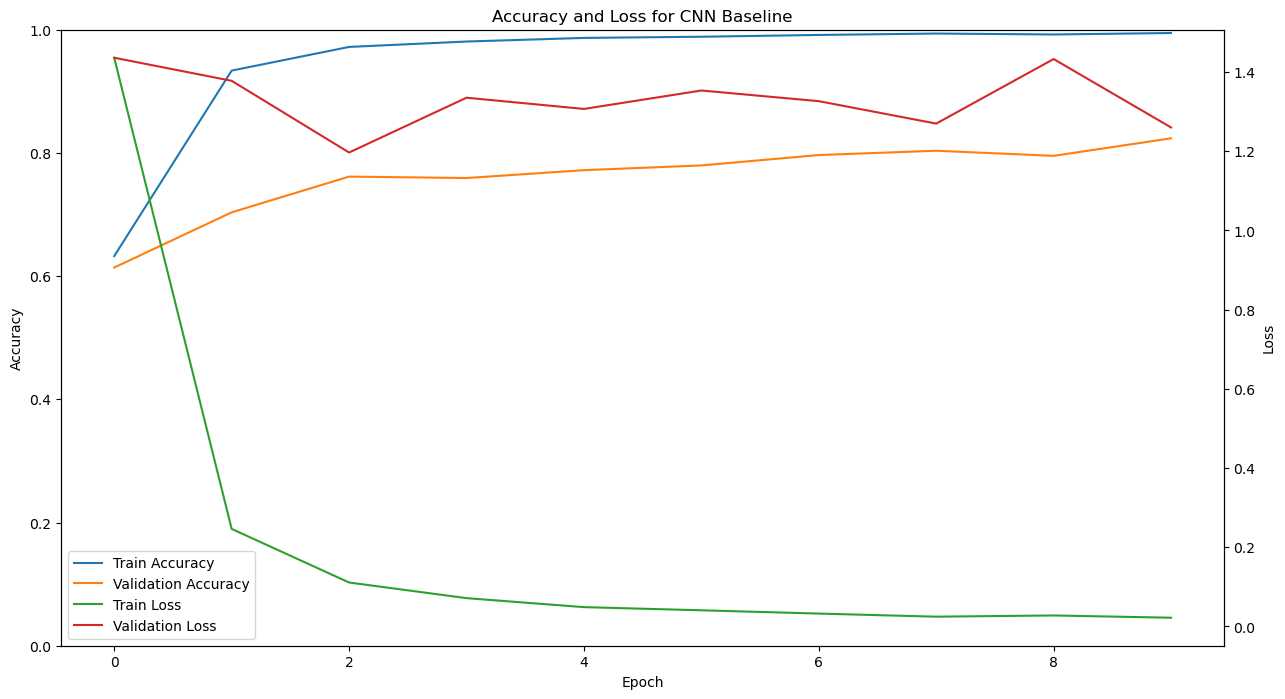

In [27]:
# fit / train the model
start_time = timeit.default_timer()

cnn_baseline_history = cnn_baseline.fit(x=train_images_Pt, y=train_labels_P, validation_data=(valid_images_Pt, valid_labels_P), epochs=10, batch_size=64)

end_time = timeit.default_timer()
print(f"Execution time: {end_time - start_time} seconds")

plot_accuracy_loss(cnn_baseline_history, "CNN Baseline")


It appears that the model is overfitting the data.  I will try to see how the model performs with regularization and dropout layers to the model to see if that helps.

### CNN Model with Dropout and Regularization

In [28]:
# Define the model architecture
cnn_regularized_dropout = keras.Sequential([
    # strides and padding are the default values but adding them for better understanding
    layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1,1), padding='valid', activation='relu', input_shape=train_images_Pt.shape[1:]), # convulation layer + relu activation
    layers.MaxPooling2D((2, 2)), # max pooling layer
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'), # convulation layer + relu activation 
    layers.MaxPooling2D((2, 2)),# max pooling layer

    layers.Flatten(), # flatten layer
    
    layers.Dense(64, activation='relu', kernel_regularizer = L2(0.001)), # L2 <- driving the parameters towards zero - decreases complexity
    layers.Dropout(0.5), # dropout layer - probability chance of dropping a neuron
    layers.Dense(43, activation='softmax')  # 43 classes
])

# configure parameters for the model
loss = keras.losses.CategoricalCrossentropy() # loss function for multi-class classification
optimizer = keras.optimizers.Adam(learning_rate=0.001) # adam optimizer
metrics = [keras.metrics.CategoricalAccuracy()] # accuracy metric

# compile the model
cnn_regularized_dropout.compile(optimizer=optimizer, loss=loss, metrics=metrics)

cnn_regularized_dropout.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                73792     
_________________________________________________________________
dropout (Dropout)            (None, 64)               

Epoch 1/10
452/452 [==============================] - 13s 28ms/step - loss: 3.0309 - categorical_accuracy: 0.2226 - val_loss: 1.5316 - val_categorical_accuracy: 0.6036
Epoch 2/10
452/452 [==============================] - 12s 28ms/step - loss: 1.1025 - categorical_accuracy: 0.6951 - val_loss: 1.0590 - val_categorical_accuracy: 0.7225
Epoch 3/10
452/452 [==============================] - 12s 27ms/step - loss: 0.7367 - categorical_accuracy: 0.8030 - val_loss: 0.8887 - val_categorical_accuracy: 0.7894
Epoch 4/10
452/452 [==============================] - 12s 28ms/step - loss: 0.5875 - categorical_accuracy: 0.8535 - val_loss: 0.8062 - val_categorical_accuracy: 0.8112
Epoch 5/10
452/452 [==============================] - 15s 34ms/step - loss: 0.5174 - categorical_accuracy: 0.8748 - val_loss: 0.7209 - val_categorical_accuracy: 0.8391
Epoch 6/10
452/452 [==============================] - 16s 35ms/step - loss: 0.4486 - categorical_accuracy: 0.8954 - val_loss: 0.6909 - val_categorical_accuracy:

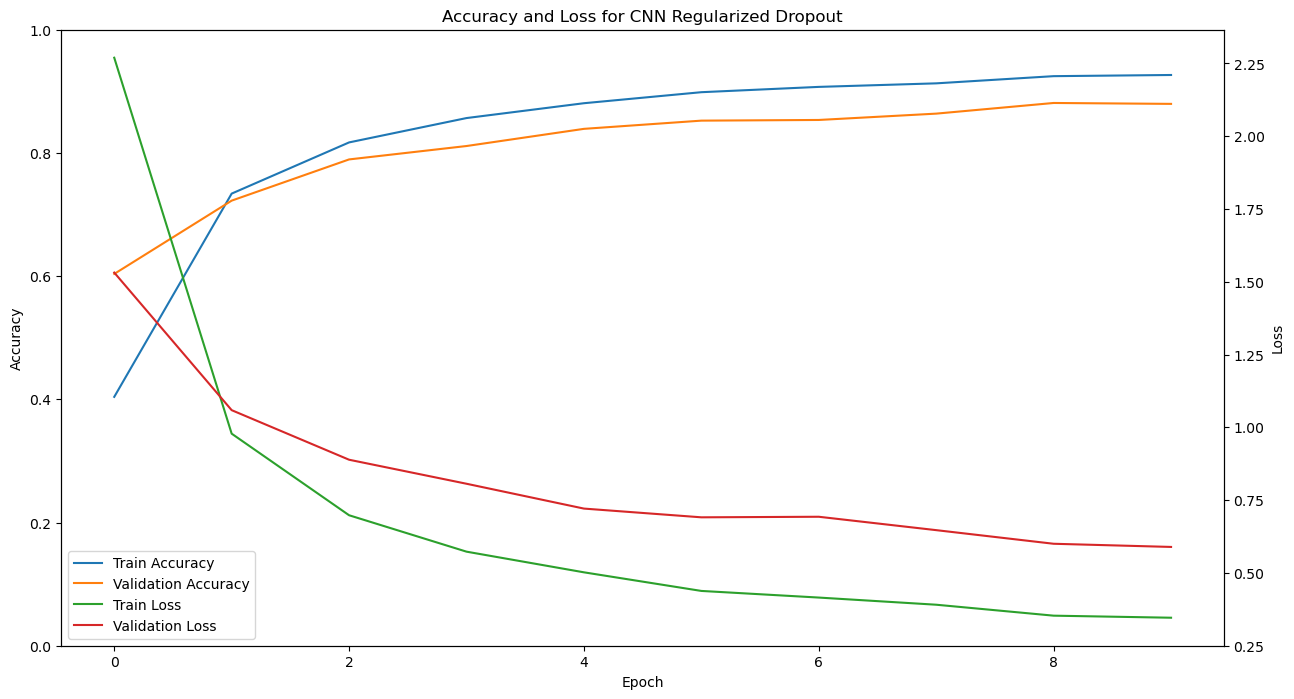

In [29]:
# fit / train the model
start_time = timeit.default_timer()

cnn_regularized_dropout_history = cnn_regularized_dropout.fit(x=train_images_Pt, y=train_labels_P, validation_data=(valid_images_Pt, valid_labels_P), epochs=10, batch_size=64)

end_time = timeit.default_timer()
print(f"Execution time: {end_time - start_time} seconds")

plot_accuracy_loss(cnn_regularized_dropout_history, "CNN Regularized Dropout")

Let's try with Le-Net5 inspired architecture.

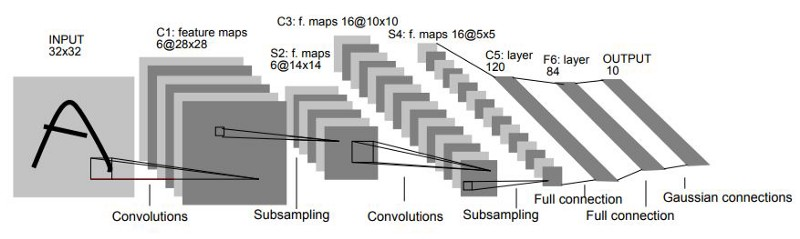

### LeNet5 Model

In [ ]:
# Define the model architecture
lenet_baseline = keras.Sequential([
    # strides and padding are the default values but adding them for better understanding
    layers.Conv2D(filters=6, kernel_size=(5, 5), strides=(1,1), padding='valid', activation='relu', input_shape=train_images_Pt.shape[1:]), # convulation layer + relu activation
    layers.AveragePooling2D(pool_size=(2, 2), strides=(2,2)), # average pooling layer
    layers.Conv2D(filters=16, kernel_size=(5, 5), strides=(1,1), activation='relu'), # convulation layer + relu activation 
    layers.AveragePooling2D(pool_size=(2, 2), strides=(2,2)),# max pooling layer

    layers.Flatten(), # flatten layer
    
    layers.Dense(120, activation='relu'), # fully connected layer + relu activation
    layers.Dense(84, activation='relu'), # fully connected layer + relu activation
    layers.Dense(43, activation='softmax')  # 43 classes
])

loss = keras.losses.CategoricalCrossentropy() # loss function for multi-class classification
optimizer = keras.optimizers.Adam(learning_rate=0.001) # adam optimizer
metrics = [keras.metrics.CategoricalAccuracy()] # accuracy metric

# compile the model
lenet_baseline.compile(optimizer=optimizer, loss=loss, metrics=metrics)

print(lenet_baseline.summary()) # see model architecture

In [ ]:
# fit / train the model
start_time = timeit.default_timer()

lenet_baseline_history = lenet_baseline.fit(x=train_images_Pt, y=train_labels_P, validation_data=(valid_images_Pt, valid_labels_P), epochs=10, batch_size=64)

end_time = timeit.default_timer()
print(f"Execution time: {end_time - start_time} seconds")

plot_accuracy_loss(lenet_baseline_history, "LeNet Baseline")

This LeNet-5 architecture doesn't perform as well as our original model. Let's try to add dropout layers to the model to see if that helps.

### LeNet5 Model with Dropout and Regularization

In [ ]:
# Define the model architecture
lenet_regularized_dropout = keras.Sequential([
    # strides and padding are the default values but adding them for better understanding
    layers.Conv2D(filters=6, kernel_size=(5, 5), strides=(1,1), padding='valid', activation='relu', input_shape=train_images_Pt.shape[1:]), # convulation layer + relu activation
    layers.AveragePooling2D(pool_size=(2, 2), strides=(2,2)), # average pooling layer
    layers.Conv2D(filters=16, kernel_size=(5, 5), strides=(1,1), activation='relu'), # convulation layer + relu activation 
    layers.AveragePooling2D(pool_size=(2, 2), strides=(2,2)),# max pooling layer

    layers.Flatten(), # flatten layer
    
    layers.Dense(120, activation='relu', kernel_regularizer = L2(0.001)), # L2 <- driving the parameters towards zero - decreases complexity
    layers.Dropout(0.5), # dropout layer - probability chance of dropping a neuron
    layers.Dense(84, activation='relu', kernel_regularizer = L2(0.001)), # L2 <- driving the parameters towards zero - decreases complexity
    layers.Dropout(0.5), # dropout layer - probability chance of dropping a neuron
    layers.Dense(43, activation='softmax')  # 43 classes
])

loss = keras.losses.CategoricalCrossentropy() # loss function for multi-class classification
optimizer = keras.optimizers.Adam(learning_rate=0.001) # adam optimizer
metrics = [keras.metrics.CategoricalAccuracy()] # accuracy metric

# compile the model
lenet_regularized_dropout.compile(optimizer=optimizer, loss=loss, metrics=metrics)

print(lenet_regularized_dropout.summary()) # see model architecture

In [ ]:
# fit / train the model
start_time = timeit.default_timer()

lenet_regularized_dropout_history = lenet_regularized_dropout.fit(x=train_images_Pt, y=train_labels_P, validation_data=(valid_images_Pt, valid_labels_P), epochs=10, batch_size=64)

end_time = timeit.default_timer()
print(f"Execution time: {end_time - start_time} seconds")

plot_accuracy_loss(lenet_regularized_dropout_history, "LeNet Regularized Dropout")

It appears our initially CNN model still outperforms the LeNet-5 model.  Let's save this model and then evaluate it on the test set.

In [ ]:
# save all the models
#cnn_baseline.save('cnn_baseline')
#cnn_regularized_dropout.save('cnn_regularized_dropout')
#lenet_baseline.save('lenet_baseline')
#lenet_regularized_dropout.save('lenet_regularized_dropout')

In [30]:
test_loss, test_accuracy = cnn_regularized_dropout.evaluate(test_images_Pt, test_labels_P)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

138/138 [==============================] - 3s 9ms/step - loss: 0.5204 - categorical_accuracy: 0.9073
Test Loss: 0.5204148292541504
Test Accuracy: 0.9072562456130981


### Confusion Matrix

test_predicted_labels shape: (4410,)
test_true_labels shape: (4410,)
test_predicted_labels: [41 41 41 ... 25 25 25]
test_true_labels: [41 41 41 ... 25 25 25]


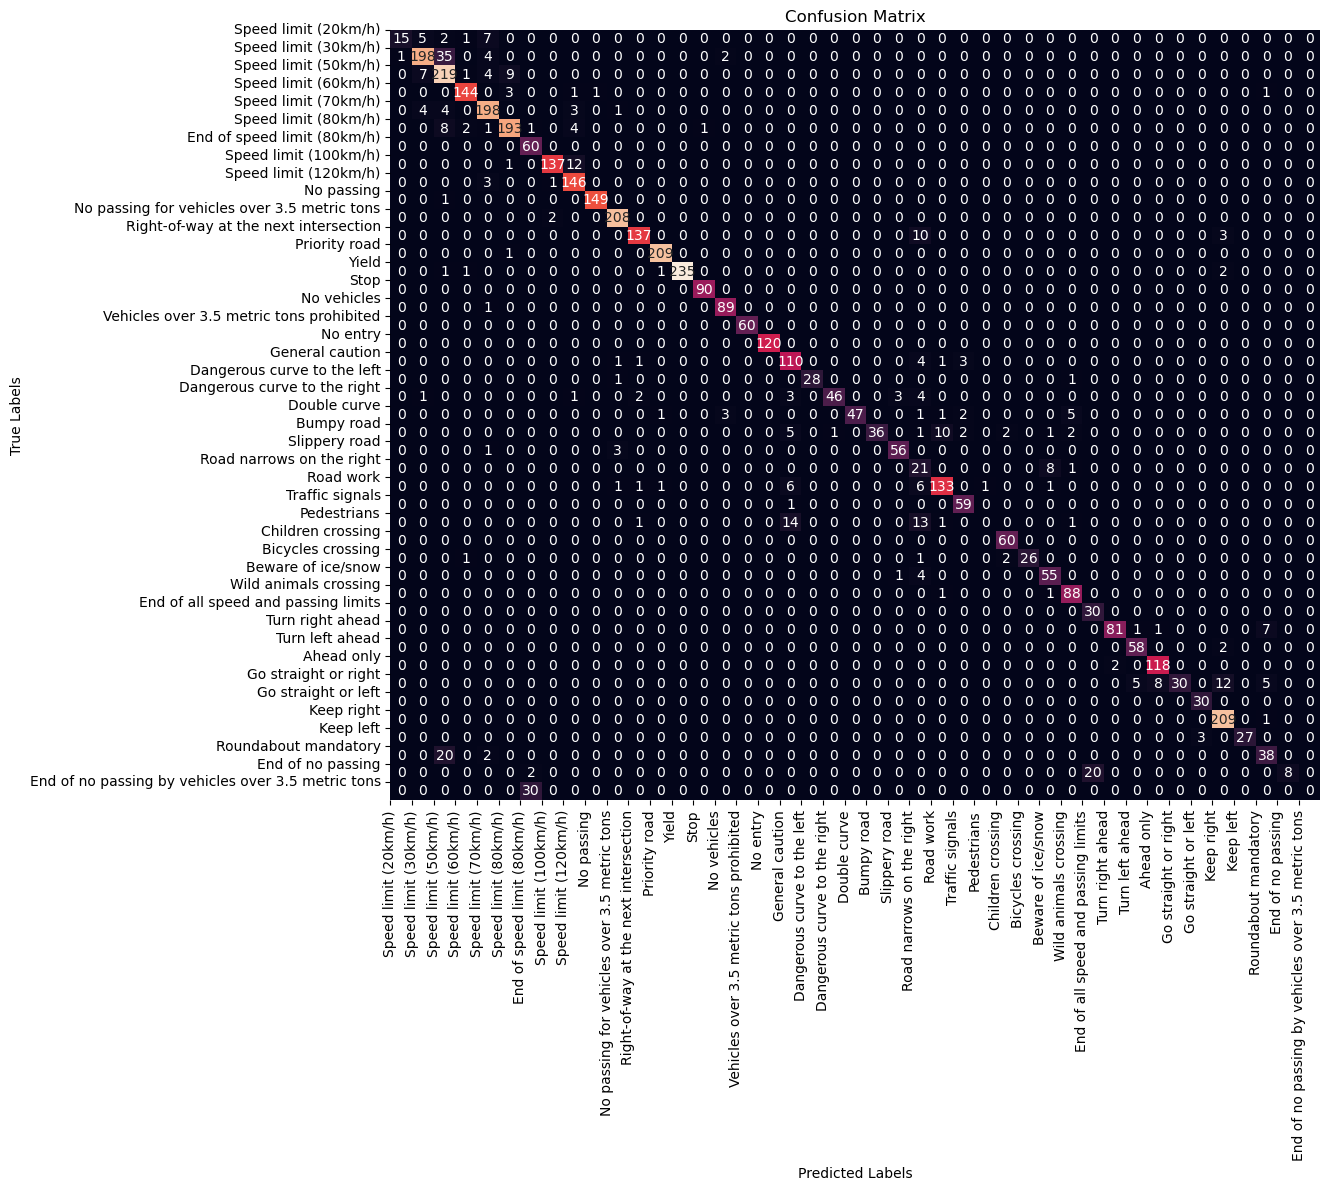

In [31]:
# Make predictions on the test data
test_predictions = cnn_regularized_dropout.predict(test_images_Pt)

# Convert predictions from one-hot encoding to class labels
test_predicted_labels = np.argmax(test_predictions, axis=1)

# Convert true labels from one-hot encoding to class labels
test_true_labels = np.argmax(test_labels_P, axis=1)

# Check the shapes and values of test_predicted_labels and test_true_labels
print("test_predicted_labels shape:", test_predicted_labels.shape)
print("test_true_labels shape:", test_true_labels.shape)
print("test_predicted_labels:", test_predicted_labels)
print("test_true_labels:", test_true_labels)

# Create a confusion matrix
confusion_matrix = tf.math.confusion_matrix(test_true_labels, test_predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(np.arange(len(signnames)), [signnames[i] for i in range(len(signnames))], rotation='vertical')
plt.yticks(np.arange(len(signnames)), [signnames[i] for i in range(len(signnames))], rotation='horizontal')
plt.show()

### Plot Misclassified Images

In [69]:
import numpy as np

def plot_misclassified_images(images, true_labels, predicted_labels, signnames):
    """
    Plots the misclassified traffic sign images.

    Args:
        images (np.ndarray): Array of traffic sign images.
        true_labels (np.ndarray): Array of true labels.
        predicted_labels (np.ndarray): Array of predicted labels.
        signnames (dict): Dictionary containing sign names.
    """
    misclassified_indices = np.where(true_labels != predicted_labels)[0]
    # take 5 random misclassified indices
    random_misclassified_indices = np.random.choice(misclassified_indices, 5, replace=False)

    for index in random_misclassified_indices:
        true_label = true_labels[index]
        predicted_label = predicted_labels[index]
        image = images[index]
        # plot the image
        plt.figure(figsize=(5, 5))
        plt.imshow(image)
        # plot image of the incorrect label
        plt.title("True label: {} | Predicted: {}".format(signnames[true_label], signnames[predicted_label]))




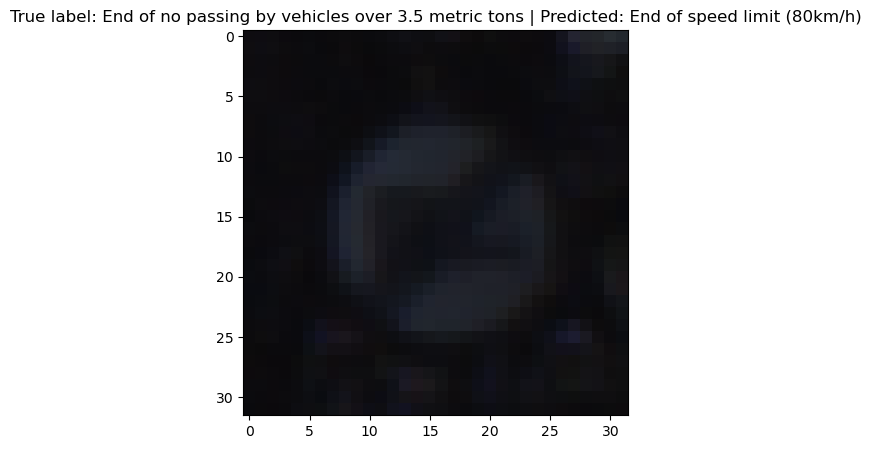

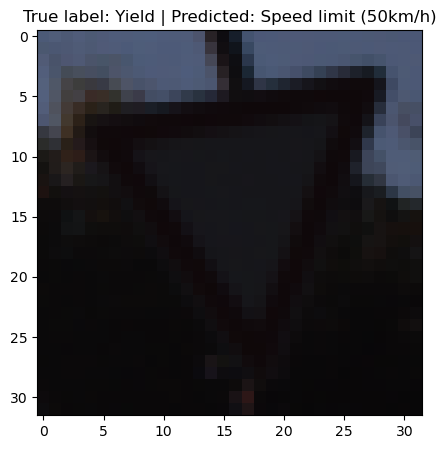

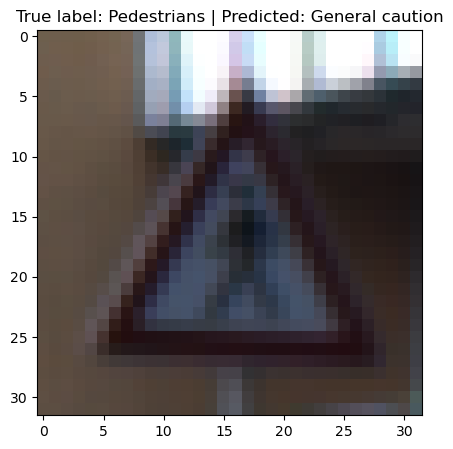

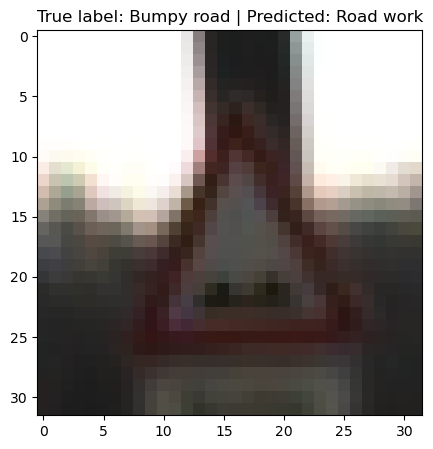

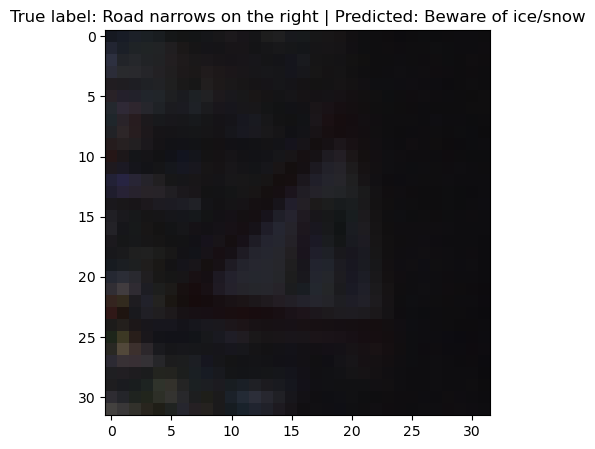

In [70]:
#print(np.where(test_true_labels != test_predicted_labels)[0])
plot_misclassified_images(test_images_Pt, test_true_labels, test_predicted_labels, signnames)

### Activation Heatmap

In [190]:
test_images_P[0].shape

# add None dimension to the beginning of the shape
test_images_Pl = np.expand_dims(test_images_P, axis=0)

test_images_Pl[0].shape
test_images_Pl[0]

# change shape to (None, 32, 32, 3)
#test_images_P2[0] = test_images_Pt[0].reshape(-1, 32, 32, 3)


array([[[[0.05098039, 0.04705882, 0.04705882],
         [0.04705882, 0.04313725, 0.04705882],
         [0.05098039, 0.04313725, 0.04313725],
         ...,
         [0.05490196, 0.04705882, 0.04313725],
         [0.05098039, 0.04705882, 0.04313725],
         [0.04705882, 0.04705882, 0.04313725]],

        [[0.05098039, 0.04705882, 0.05098039],
         [0.04705882, 0.04313725, 0.04705882],
         [0.05098039, 0.04705882, 0.04705882],
         ...,
         [0.05098039, 0.04705882, 0.04313725],
         [0.05098039, 0.04705882, 0.04313725],
         [0.04705882, 0.04705882, 0.04313725]],

        [[0.05098039, 0.04705882, 0.05098039],
         [0.04705882, 0.04313725, 0.04705882],
         [0.04705882, 0.04705882, 0.04705882],
         ...,
         [0.05098039, 0.04705882, 0.04313725],
         [0.05098039, 0.04705882, 0.04313725],
         [0.04705882, 0.04705882, 0.04313725]],

        ...,

        [[0.0627451 , 0.05882353, 0.05882353],
         [0.05882353, 0.05490196, 0.05490196]

In [200]:
model = cnn_regularized_dropout

# create a new model that outputs an intermediate layer
intermediate_layer_model = keras.Model(inputs=model.inputs, outputs=model.layers[-1].output)

#prepare input image
image = test_images_Pl[0]

# run inference to obtain the activations
activations = intermediate_layer_model.predict(image)
print(activations)

# convert to numpy array
activations = np.array(activations)
print(activations)

# get the maximum activation for each image
max_activations = np.max(activations, axis=1)

# Assuming activations is a 1D tensor with shape (num_classes,)
# Create a blank canvas to visualize the activations
canvas = np.zeros(image.shape)

# Scale activations to the range [0, 1]
activations = activations / np.max(activations)

# Reshape activations to match the shape of the image
reshaped_activations = np.reshape(activations, (1, 1, 1, activations.shape[0]))

# Map activations to the canvas
canvas += reshaped_activations * image

# Plot the original image and the overlay of activations
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis('off')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(canvas)
plt.axis('off')
plt.title('Activations Overlay')

plt.show()



[[3.5466655e-08 2.6205850e-08 3.6648335e-06 ... 3.0044541e-07
  9.3009728e-01 3.6154594e-02]
 [5.2712016e-07 9.1566693e-07 5.9127127e-05 ... 4.7829822e-06
  9.0990275e-01 9.6693253e-03]
 [7.7599509e-08 6.0839113e-08 8.5357915e-06 ... 5.6853986e-07
  9.2353493e-01 3.3573586e-02]
 ...
 [1.2404918e-05 7.0162606e-03 2.3243187e-02 ... 4.7201375e-04
  1.2115381e-06 6.4100200e-06]
 [3.1212223e-04 8.8224038e-03 1.0365215e-02 ... 2.7006195e-04
  1.1023650e-06 4.7606775e-07]
 [1.1055477e-05 5.9750592e-03 1.3041498e-02 ... 1.1066677e-03
  8.9247766e-07 1.0858658e-05]]
[[3.5466655e-08 2.6205850e-08 3.6648335e-06 ... 3.0044541e-07
  9.3009728e-01 3.6154594e-02]
 [5.2712016e-07 9.1566693e-07 5.9127127e-05 ... 4.7829822e-06
  9.0990275e-01 9.6693253e-03]
 [7.7599509e-08 6.0839113e-08 8.5357915e-06 ... 5.6853986e-07
  9.2353493e-01 3.3573586e-02]
 ...
 [1.2404918e-05 7.0162606e-03 2.3243187e-02 ... 4.7201375e-04
  1.2115381e-06 6.4100200e-06]
 [3.1212223e-04 8.8224038e-03 1.0365215e-02 ... 2.7006195e-

ValueError: cannot reshape array of size 189630 into shape (1,1,1,4410)

In [156]:
cnn_regularized_dropout.inputs

[<KerasTensor: shape=(None, 32, 32, 3) dtype=float32 (created by layer 'conv2d_2_input')>]

In [165]:
cnn_regularized_dropout.layers[5].output

<KerasTensor: shape=(None, 64) dtype=float32 (created by layer 'dense_2')>

In [159]:
visualize_activation_heatmap(cnn_regularized_dropout, train_images_Pt[0])

Predicted label: 23


LookupError: No gradient defined for operation 'IteratorGetNext' (op type: IteratorGetNext)

In [ ]:
# 1) Save whole model
# SavedModel or HDF5 (Hierarchical Data Format)
#model.save('traffic_signs_model_initial')

# 2) Save only weights
#model.save_weights('traffic_signs_model_weights_initial')

# 3) Save only architecture
'''
model_arch = model.to_json()
with open('traffic_signs_model_architecture_initial.json', 'w') as f:
    f.write(model_arch)
with open('traffic_signs_model_architecture_initial.json', 'r') as f:
    model_architecture = f.read()

new_model = keras.models.model_from_json(model_architecture)
# this will only load the architecture and not the weights

new_model = keras.models.load_model('traffic_signs_model_initial')
new_model.evaluate(test_images_P, test_labels, verbose=2)
'''